# **Gender Classification**
---

## Setup Environment

In [1]:
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [4]:
import tensorflow
tensorflow.__version__

'2.15.0'

## Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import vgg16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Input, Dense, Flatten
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics import confusion_matrix

In [5]:
import os
import shutil
import random
from pathlib import Path

In [6]:
classes = {0:'Man', 1:'Woman'}

In [7]:
print(classes[0])

Man


## Create Dataset Folder

In [8]:
Path('/kaggle/working/Gender').mkdir(parents=True, exist_ok=True)

In [9]:
Path('/kaggle/working/Gender/Man').mkdir(parents=True, exist_ok=True)

In [10]:
Path('/kaggle/working/Gender/Woman').mkdir(parents=True, exist_ok=True)

## Copy images to the folder

In [11]:
for i in os.listdir("/kaggle/input/gender-recognizer/dataset/MEN"):
    shutil.copy(f"/kaggle/input/gender-recognizer/dataset/MEN/{i}", "/kaggle/working/Gender/Man")

In [12]:
for i in os.listdir("/kaggle/input/gender-recognizer/dataset/WOMAN"):
    if i =="MEN":
        continue
    shutil.copy(f"/kaggle/input/gender-recognizer/dataset/WOMAN/{i}", "/kaggle/working/Gender/Woman")

## Data Gathering

In [14]:
data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = data_gen.flow_from_directory("/kaggle/working/Gender",
                                         target_size=(224,224),
                                         batch_size=64,
                                         class_mode = 'binary',
                                         shuffle=True,
                                         subset='training')

test_data = data_gen.flow_from_directory("/kaggle/working/Gender",
                                         target_size=(224,224),
                                         batch_size=64,
                                         class_mode = 'binary',
                                         shuffle=False,
                                         subset='validation')

Found 1033 images belonging to 2 classes.
Found 258 images belonging to 2 classes.


In [15]:
print("Image Shape:", train_data.image_shape)

Image Shape: (224, 224, 3)


In [16]:
print("Classes:", train_data.class_indices)

Classes: {'Man': 0, 'Woman': 1}


## Modeling

In [17]:
vgg16_model = vgg16.VGG16(include_top=False, input_shape=(224,224,3), weights='imagenet')
vgg16_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [19]:
vgg16_model.trainable = False
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [20]:
model = Sequential()
model.add(vgg16_model)
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 4097      
                                                                 
Total params: 134264641 (512.18 MB)
Trainable params: 11

## Training

In [21]:
from tensorflow.keras.callbacks import EarlyStopping
cb = EarlyStopping(patience=10, monitor='val_Accuracy', mode="max", 
                   restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['Accuracy'])

results = model.fit(train_data, epochs=50, validation_data=test_data,
                   steps_per_epoch=len(train_data), validation_steps=len(test_data),
                   callbacks=cb)

Epoch 1/50


I0000 00:00:1722493096.120341     142 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17/17 [==============================] - 41s 1s/step - loss: 11.6077 - Accuracy: 0.5905 - val_loss: 0.5621 - val_Accuracy: 0.7674
Epoch 2/50
17/17 [==============================] - 15s 913ms/step - loss: 0.2262 - Accuracy: 0.9071 - val_loss: 0.4112 - val_Accuracy: 0.8566
Epoch 3/50
17/17 [==============================] - 16s 919ms/step - loss: 0.1023 - Accuracy: 0.9593 - val_loss: 0.3753 - val_Accuracy: 0.8682
Epoch 4/50
17/17 [==============================] - 15s 881ms/step - loss: 0.0328 - Accuracy: 0.9903 - val_loss: 0.5439 - val_Accuracy: 0.8605
Epoch 5/50
17/17 [==============================] - 16s 917ms/step - loss: 0.0075 - Accuracy: 1.0000 - val_loss: 0.4439 - val_Accuracy: 0.8798
Epoch 6/50
17/17 [==============================] - 15s 862ms/step - loss: 0.0029 - Accuracy: 0.9990 - val_loss: 0.5374 - val_Accuracy: 0.8721
Epoch 7/50
17/17 [==============================] - 15s 875ms/step - loss: 8.0949e-04 - Accuracy: 1.0000 - val_loss: 0.5673 - val_Accuracy: 0.8721
Epoch 8/

## Evaluation

In [22]:
loss, accuracy = model.evaluate(test_data)

5/5 [==============================] - 3s 345ms/step - loss: 0.6718 - Accuracy: 0.8876


In [23]:
print("Test Accuracy: ", round(accuracy*100,2), "%\nLoss Value: ",loss, sep='')

Test Accuracy: 88.76%
Loss Value: 0.6718363761901855


In [24]:
results.history['val_loss']

[0.5620964169502258,
 0.41115814447402954,
 0.3753063976764679,
 0.543901801109314,
 0.4439188838005066,
 0.5374053120613098,
 0.5672904849052429,
 0.6070976257324219,
 0.5807778835296631,
 0.587578535079956,
 0.6172400116920471,
 0.6048317551612854,
 0.6405785083770752,
 0.6302990317344666,
 0.6506032347679138,
 0.6474663615226746,
 0.6678661108016968,
 0.678673267364502,
 0.6718363761901855,
 0.6671087145805359,
 0.6883462071418762,
 0.7053108215332031,
 0.6858510971069336,
 0.7011071443557739,
 0.715742826461792,
 0.7152124643325806,
 0.7173342704772949,
 0.7246882915496826,
 0.7313311696052551]

In [25]:
results.history['val_Accuracy']

[0.7674418687820435,
 0.856589138507843,
 0.8682170510292053,
 0.8604651093482971,
 0.8798449635505676,
 0.8720930218696594,
 0.8720930218696594,
 0.8720930218696594,
 0.8759689927101135,
 0.8798449635505676,
 0.8798449635505676,
 0.8798449635505676,
 0.8837209343910217,
 0.8798449635505676,
 0.8837209343910217,
 0.8798449635505676,
 0.8837209343910217,
 0.8837209343910217,
 0.8875969052314758,
 0.8798449635505676,
 0.8837209343910217,
 0.8837209343910217,
 0.8798449635505676,
 0.8875969052314758,
 0.8837209343910217,
 0.8759689927101135,
 0.8798449635505676,
 0.8759689927101135,
 0.8837209343910217]

In [26]:
i = max(results.history['val_Accuracy'])
i = results.history['val_Accuracy'].index(i)
i

18

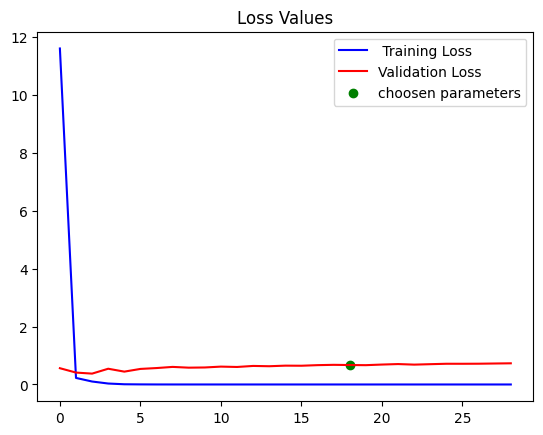

In [27]:
fig = plt.figure()
plt.plot(results.history['loss'], c='blue', label=' Training Loss')
plt.plot(results.history['val_loss'], c='red', label='Validation Loss')
plt.scatter(i ,results.history['val_loss'][i], c='green', label='choosen parameters', marker='o')
plt.title("Loss Values")
plt.legend(loc="upper right")
plt.show()

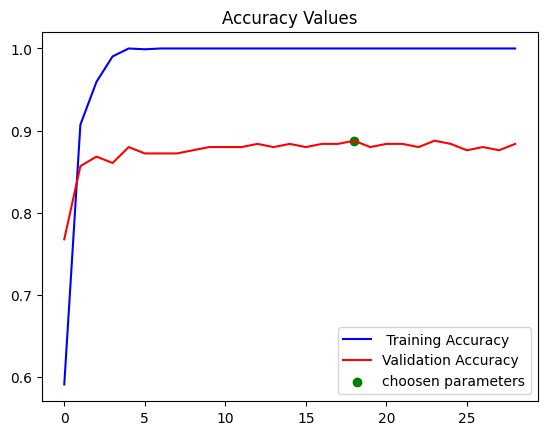

In [28]:
fig = plt.figure()
plt.plot(results.history['Accuracy'], c='blue', label=' Training Accuracy')
plt.plot(results.history['val_Accuracy'], c='red', label='Validation Accuracy')
plt.scatter(i ,results.history['val_Accuracy'][i], c='green', label='choosen parameters', marker='o')
plt.title("Accuracy Values")
plt.legend(loc="lower right")
plt.show()

In [47]:
yp = (model.predict(test_data)>=0.5).astype(int).reshape(-1,)
yp

5/5 [==============================] - 3s 430ms/step


array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [48]:
yp.shape

(258,)

In [49]:
m = confusion_matrix(test_data.labels, yp)
m

array([[109,  20],
       [  9, 120]])

Heatmap



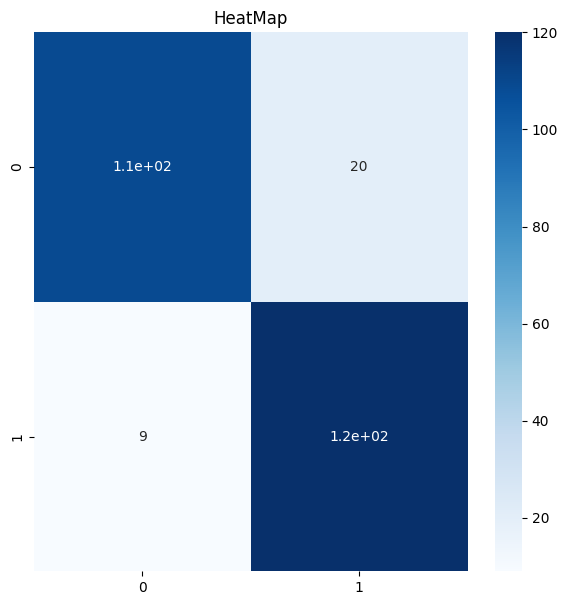

In [50]:
print("Heatmap\n")
plt.figure(figsize=(7,7))
plt.title("HeatMap")
sns.heatmap(m, annot=True, cmap='Blues')
plt.show()

## Results

In [51]:
df = pd.DataFrame({'filename':test_data.filenames,'y_actual':test_data.classes,'Y_pred':yp})
df

,filename,y_actual,Y_pred
0,Man/20240609_175821.jpg,0,0
1,Man/20240609_175941.jpg,0,0
2,Man/20240609_175959.jpg,0,0
3,Man/20240609_180022.jpg,0,0
4,Man/20240609_180035.jpg,0,1
...,...,...,...
253,Woman/0127.jpg,1,1
254,Woman/0128.jpg,1,1
255,Woman/0129.jpg,1,1
256,Woman/0130.jpg,1,1


## Random Images Testing

In [29]:
mens = os.listdir('/kaggle/working/Gender/Man')
womans = os.listdir('/kaggle/working/Gender/Woman')
def get_random_img(gender):
    if gender == 'man':
        i = random.randint(0, len(mens)-1)
        name = mens[i]
        img = load_img(f'/kaggle/working/Gender/Man/{name}',target_size=(224,224))
        return img
    else:
        i = random.randint(0, len(womans)-1)
        name = womans[i]
        img = load_img(f'/kaggle/working/Gender/Woman/{name}',target_size=(224,224))
        return img

Text(0.5, 1.0, 'Actual: Woman')

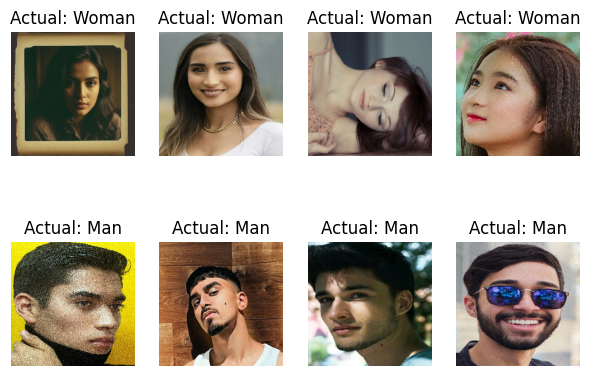

In [52]:
fig = plt.figure(figsize=(15,10))
# plt.grid=False
fig.add_subplot(1, 8, 1)
plt.axis('off')
img1 = get_random_img('man')
plt.imshow(img1)
plt.title('Actual: Man')
# _______________________________
fig.add_subplot(1, 8, 2)
plt.axis('off')
img2 = get_random_img('man')
plt.imshow(img2)
plt.title('Actual: Man')
# _______________________________
fig.add_subplot(1, 8, 3)
plt.axis('off')
img3 = get_random_img('man')
plt.imshow(img3)
plt.title('Actual: Man')
# _______________________________
fig.add_subplot(1, 8, 4)
plt.axis('off')
img4 = get_random_img('man')
plt.imshow(img4)
plt.title('Actual: Man')
# _______________________________
fig.add_subplot(2, 8, 1)
plt.axis('off')
img5 = get_random_img('woman')
plt.imshow(img5)
plt.title('Actual: Woman')
# _______________________________
fig.add_subplot(2, 8, 2)
plt.axis('off')
img6 = get_random_img('woman')
plt.imshow(img6)
plt.title('Actual: Woman')
# _______________________________
fig.add_subplot(2, 8, 3)
plt.axis('off')
img7 = get_random_img('woman')
plt.imshow(img7)
plt.title('Actual: Woman')
# _______________________________
fig.add_subplot(2, 8, 4)
plt.axis('off')
img8 = get_random_img('woman')
plt.imshow(img8)
plt.title('Actual: Woman')

1/1 [==============================] - 0s 18ms/step


Text(0.5, 1.0, 'Predicted: Woman')

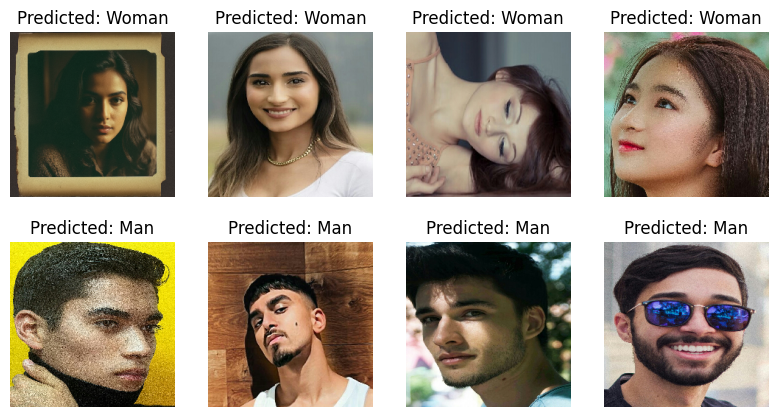

In [53]:
fig = plt.figure(figsize=(20,10))
# plt.grid=False
fig.add_subplot(1, 8, 1)
plt.axis('off')
plt.imshow(img1)
img = img_to_array(img1)
img = img / 255
img = img.reshape(1,224,224,3)
p = (model.predict(img)>=0.5).astype(int)[0][0]
plt.title(f"Predicted: {classes[p]}")
# _______________________________
fig.add_subplot(1, 8, 2)
plt.axis('off')
plt.imshow(img2)
img = img_to_array(img2)
img = img / 255
img = img.reshape(1,224,224,3)
p = (model.predict(img)>=0.5).astype(int)[0][0]
plt.title(f"Predicted: {classes[p]}")
# _______________________________
fig.add_subplot(1, 8, 3)
plt.axis('off')
plt.imshow(img3)
img = img_to_array(img3)
img = img / 255
img = img.reshape(1,224,224,3)
p = (model.predict(img)>=0.5).astype(int)[0][0]
plt.title(f"Predicted: {classes[p]}")
# _______________________________
fig.add_subplot(1, 8, 4)
plt.axis('off')
plt.imshow(img4)
img = img_to_array(img4)
img = img / 255
img = img.reshape(1,224,224,3)
p = (model.predict(img)>=0.5).astype(int)[0][0]
plt.title(f"Predicted: {classes[p]}")
# _______________________________
fig.add_subplot(2, 8, 1)
plt.axis('off')
plt.imshow(img5)
img = img_to_array(img5)
img = img / 255
img = img.reshape(1,224,224,3)
p = (model.predict(img)>=0.5).astype(int)[0][0]
plt.title(f"Predicted: {classes[p]}")
# _______________________________
fig.add_subplot(2, 8, 2)
plt.axis('off')
plt.imshow(img6)
img = img_to_array(img6)
img = img / 255
img = img.reshape(1,224,224,3)
p = (model.predict(img)>=0.5).astype(int)[0][0]
plt.title(f"Predicted: {classes[p]}")
# _______________________________
fig.add_subplot(2, 8, 3)
plt.axis('off')
plt.imshow(img7)
img = img_to_array(img7)
img = img / 255
img = img.reshape(1,224,224,3)
p = (model.predict(img)>=0.5).astype(int)[0][0]
plt.title(f"Predicted: {classes[p]}")
# _______________________________
fig.add_subplot(2, 8, 4)
plt.axis('off')
plt.imshow(img8)
img = img_to_array(img8)
img = img / 255
img = img.reshape(1,224,224,3)
p = (model.predict(img)>=0.5).astype(int)[0][0]
plt.title(f"Predicted: {classes[p]}")

---

## Saving The Model

In [54]:
model.save("Gender.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Download The Model

In [58]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink(r'Gender.h5')

/kaggle/working


/kaggle/working/Gender.h5

---

## Decrease Model Space

In [ ]:
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 4097      
                                                                 
Total params: 134264641 (512.18 MB)
Trainable params:

In [ ]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflitemodel1 = converter.convert()
with open ("Gender.tflite",'wb') as f:
    f.write(tflitemodel1)

INFO:tensorflow:Assets written to: C:\Users\bebon\AppData\Local\Temp\tmpxjqip3f8\assets


INFO:tensorflow:Assets written to: C:\Users\bebon\AppData\Local\Temp\tmpxjqip3f8\assets
